# Demo ARMA node: filtering

In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using Plots
pyplot();

In [2]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov
using ARMA

## Data generation

In [3]:
# Parameters
θ_true = [0.7, -.2]
η_true = [1.0, 1.0]
τ_true = 1e4

# Orders
M1 = length(θ_true)
M2 = length(η_true)
M = M1 + M2

# Transient period
tt = 10

# Time horizon
T = 400

# Observation array
output = zeros(T+tt,)
errors = zeros(T+tt,)

# First 2 outputs
output[1] = 0.0
output[2] = 0.0

for k = 1:T+tt
    
    # Errors
    errors[k] = sqrt(inv(τ_true))*randn(1)[1]
    
    if k > max(M1,M2)
   
        # Autoregressive moving average function plus noise
        output[k] = θ_true'*output[k-1:-1:k-M1] + η_true'*errors[k-1:-1:k-M2] + errors[k]
        
    end
end

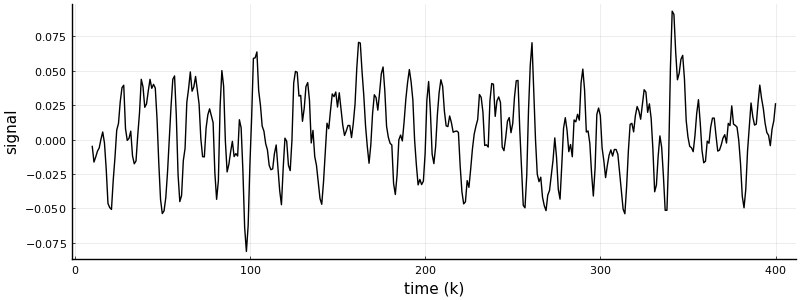

In [4]:
plot(tt:T, output[tt:T], color="black", label="", xlabel="time (k)", ylabel="signal", size=(800,300))

## Model specification

In [5]:
graph = FactorGraph()

# Observed variables
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M1,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M2,))

# Time-invariant parameters
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(M,)), placeholder(:v_θ, dims=(M,M)))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Likel7ihood
@RV y_k ~ AutoRegressiveMovingAverage(θ, z_kmin1, r_kmin1, τ)
placeholder(y_k, :y_k)

ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4689880816878949271 -->
 
 4689880816878949271 
 
 placeholder_z_kmin1 
 
<!-- 15507592607919401275 -->
 
 15507592607919401275 
 
 placeholder_m_θ 
 
<!-- 17914450031638604298 -->
 
 17914450031638604298 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 17914450031638604298--15507592607919401275 -->
 
 17914450031638604298--15507592607919401275 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 923339700775214891 -->
 
 923339700775214891 
 
 placeholder_v_θ 
 
<!-- 17914450031638604298--923339700775214891 -->
 
 17914450031638604298--923339700775214891 
 
 v_θ 
 1 out 
 3 v 
 
<!-- 8744352398661324221 -->
 
 8744352398661324221 
 
 ARMA 
 autoregressivemovingaverage_1 
 
<!-- 8744352398661324221--4689880816878949271 -->
 
 8744352398661324221--4689880816878949271 
 
 z_kmin1 
 1 out 
 3 z 
 
<!-- 8744352398661324221--17914450031638604298 -->
 
 8744352398661324221--17914450031638604298 
 
 θ 
 1 out 
 2 θ 
 
<!-- 11832911286701065064 -->
 
 11832911286701065064 
 
 Gam 
 gamma_1 
 
<!-- 8744352398661324221--11832911286701065064 -->
 
 8744352398661324221--11832911286701065064 
 
 τ 
 1 out 
 5 τ 
 
<!-- 12890774833336149790 -->
 
 12890774833336149790 
 
 placeholder_r_kmin1 
 
<!-- 8744352398661324221--12890774833336149790 -->
 
 8744352398661324221--12890774833336149790 
 
 r_kmin1 
 1 out 
 4 r 
 
<!-- 9210593320487539246 -->
 
 9210593320487539246 
 
 placeholder_b_τ 
 
<!-- 11832911286701065064--9210593320487539246 -->
 
 11832911286701065064--9210593320487539246 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 6106019319856593513 -->
 
 6106019319856593513 
 
 placeholder_a_τ 
 
<!-- 11832911286701065064--6106019319856593513 -->
 
 11832911286701065064--6106019319856593513 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 8274964186008948483 -->
 
 8274964186008948483 
 
 placeholder_y_k 
 
<!-- 8274964186008948483--8744352398661324221 -->
 
 8274964186008948483--8744352398661324221 
 
 y_k 
 1 y 
 1 out

In [6]:
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

## Inference

In [7]:
# Preallocate parameter arrays
params_θ = (zeros(T-tt,M), zeros(T-tt,M,M))
params_τ = (zeros(T-tt,1), zeros(T-tt,1))

# Initialize priors
θ_k = (ones(M,), 10 .*Matrix{Float64}(I, M,M))
τ_k = (1e4, 1e0)

marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=params_θ[1][:,1], v=params_θ[2][:,:,1]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1], b=params_τ[2][1]))

# Keep track of residuals
predictions = (zeros(T,), zeros(T,))
residuals = zeros(T,)

# Inference
@showprogress for (jj,k) in enumerate(tt+1:T)
    
    # State vector
    x_k = [output[k-1:-1:k-M1]; residuals[k-1:-1:k-M2]]
    
    # Posterior predictive
    predictions[1][k] = θ_k[1]'*x_k
    predictions[2][k] = x_k'*θ_k[2]'*x_k + inv(τ_k[1]/τ_k[2])
    
    # Compute residual
    residuals[k] = output[k] - predictions[1][k]
    
    # Set data 
    data = Dict(:y_k => output[k],
                :z_kmin1 => output[k-1:-1:k-M1],
                :r_kmin1 => residuals[k-1:-1:k-M2],
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])
    
    # Iterate updates
    for n = 1:10
        stepθ!(data, marginals)
        stepτ!(data, marginals)
    end    
    
    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
    
    # Store params
    params_θ[1][jj,:] = θ_k[1]
    params_θ[2][jj,:,:] = θ_k[2]
    params_τ[1][jj] = τ_k[1]
    params_τ[2][jj] = τ_k[2]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


## Visualization

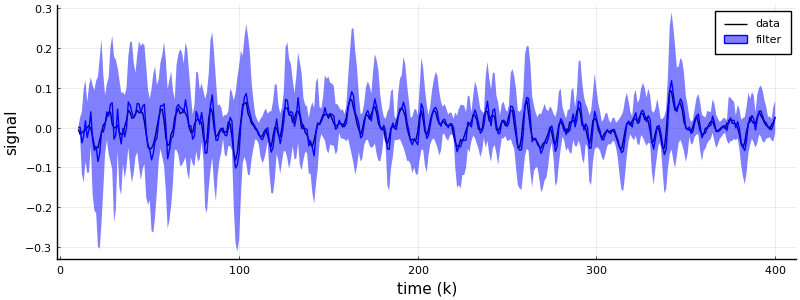

In [8]:
# Fit to past data
sd_pred = sqrt.(predictions[2])
plot(tt:T, output[tt:T], color="black", label="data", xlabel="time (k)", ylabel="signal", size=(800,300))
plot!(tt:T, predictions[1][tt:T], ribbon=[sd_pred[tt:T], sd_pred[tt:T]], color="blue", label="filter")

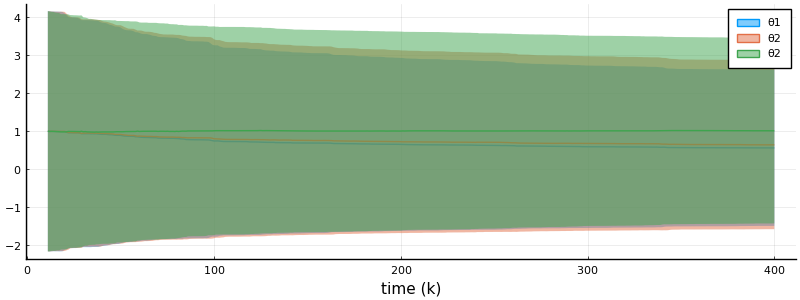

In [9]:
plot(tt+1:T, params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], xlabel="time (k)", label="θ1", size=(800,300))
plot!(tt+1:T, params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], label="θ2")
plot!(tt+1:T, params_θ[1][:,3], ribbon=[sqrt.(params_θ[2][:,3,3]) sqrt.(params_θ[2][:,3,3])], label="θ2")

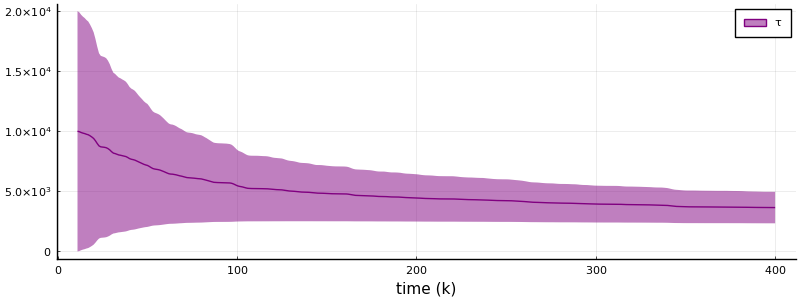

In [10]:
mτ = params_τ[1] ./ params_τ[2]
vτ = params_τ[1] ./ params_τ[2].^2

plot(tt+1:T, mτ, ribbon=[vτ vτ], color="purple", xlabel="time (k)", label="τ", size=(800,300))